# Simple Time Series Analysis with Census Data

This tutorial teaches you how to analyze changes in demographic data over time using the US Census Bureau's datasets. We'll focus on **geographic levels that don't change over time** (like states and counties) to keep things simple and avoid complex boundary adjustments.

## What You'll Learn

1. **The Golden Rule**: Only compare like survey types (ACS5↔ACS5, Decennial↔Decennial)
2. **Population trends** using decennial census data (2010 vs 2020)
3. **Income trends** using ACS 5-year data (2012 vs 2022)
4. **Best practices** for temporal analysis
5. **Visualization techniques** for demographic change
6. **How to interpret changes** in demographic indicators

## Why This Matters

Understanding demographic change over time helps with:
- Urban planning and policy decisions
- Business location and market analysis 
- Research on social and economic trends
- Grant writing and community development

## The Golden Rule of Census Time Series

**CRITICAL**: Only compare surveys of the same type!

### CORRECT Comparisons
- **Decennial 2010 ↔ Decennial 2020**: Complete population counts
- **ACS 5-year 2012 ↔ ACS 5-year 2020**: Same methodology, sample size
- **ACS 1-year 2019 ↔ ACS 1-year 2021**: Recent estimates for large areas

### WRONG Comparisons
- **ACS 1-year ↔ ACS 5-year**: Different sample sizes and time periods
- **Decennial ↔ ACS**: Different methodologies (complete count vs. sample)



## Tutorial Approach

This tutorial uses the **simple comparison approach** for stable geographies (states and counties). For smaller geographies with changing boundaries (tracts, block groups), see Tutorial 07 on advanced time series analysis with area interpolation.

## Setup: Import Libraries and API Key

First, let's import the libraries we need and set up our Census API key.

In [1]:
# Import required libraries
import pytidycensus as tc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Make plots look nicer
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("Libraries imported successfully!")
print(f"Using pytidycensus version: {tc.__version__}")

Libraries imported successfully!
Using pytidycensus version: 0.1.0


In [2]:
# Set your Census API key here
# Get a free key at: https://api.census.gov/data/key_signup.html

# UNCOMMENT and add your key:
# tc.set_census_api_key("YOUR_API_KEY_HERE")

print(" Remember to set your Census API key above!")
print(" Get one free at: https://api.census.gov/data/key_signup.html")

 Remember to set your Census API key above!
 Get one free at: https://api.census.gov/data/key_signup.html


## The Golden Rule of Census Time Series

**CRITICAL**: Only compare surveys of the same type!

### CORRECT Comparisons
- **Decennial 2010 ↔ Decennial 2020**: Complete population counts
- **ACS 5-year 2012 ↔ ACS 5-year 2020**: Same methodology, sample size
- **ACS 1-year 2019 ↔ ACS 1-year 2021**: Recent estimates for large areas

### WRONG Comparisons
- **ACS 1-year ↔ ACS 5-year**: Different sample sizes and time periods
- **Decennial ↔ ACS**: Different methodologies (complete count vs. sample)

### Why This Matters

In [3]:
# Let's demonstrate why survey type matters
print("SURVEY TYPE COMPARISON:")
print("=" * 50)
print("DECENNIAL CENSUS:")
print(" • Complete count of all households")
print(" • Very low margin of error")
print(" • Every 10 years (2010, 2020, 2030...)")
print(" • Best for: Long-term trends, small areas")
print()
print("ACS 5-YEAR:")
print(" • Sample survey (~3.5M addresses/year)")
print(" • 5 years of data combined for stability")
print(" • Available for all geographies")
print(" • Best for: Small areas, stable trends")
print()
print("ACS 1-YEAR:")
print(" • Sample survey (~3.5M addresses/year)")
print(" • Single year of data")
print(" • Only areas with 65,000+ population")
print(" • Best for: Large areas, recent trends")

SURVEY TYPE COMPARISON:
DECENNIAL CENSUS:
 • Complete count of all households
 • Very low margin of error
 • Every 10 years (2010, 2020, 2030...)
 • Best for: Long-term trends, small areas

ACS 5-YEAR:
 • Sample survey (~3.5M addresses/year)
 • 5 years of data combined for stability
 • Available for all geographies
 • Best for: Small areas, stable trends

ACS 1-YEAR:
 • Sample survey (~3.5M addresses/year)
 • Single year of data
 • Only areas with 65,000+ population
 • Best for: Large areas, recent trends


## Part 1: Population Change Analysis (Decennial Census)

Let's start by analyzing population changes in the Washington DC metro area between 2010 and 2020 using decennial census data. We'll compare **DC, Maryland, and Virginia** at the state level.

### Why Use State Level?
- State boundaries don't change over time
- No need for complex boundary adjustments
- Reliable and straightforward comparison

In [4]:
# Step 1: Get 2010 population data for DC metro states
print(" Fetching 2010 decennial census data...")
print(" Variable: P001001 (Total Population)")

# Define the states we want to analyze
metro_states = ["DC", "MD", "VA"]

# Get 2010 data
pop_2010 = tc.get_decennial(
 geography="state",
 variables={"total_pop": "P001001"}, # P001001 = Total Population in 2010
 state=metro_states,
 year=2010,
 output="wide" # Wide format puts variables as columns
)

print(f"Retrieved data for {len(pop_2010)} states")
print("\n2010 Population Data:")
print(pop_2010[['NAME', 'total_pop']].to_string(index=False))

 Fetching 2010 decennial census data...
 Variable: P001001 (Total Population)
Getting data from the 2010 decennial Census
Using Census Summary File 1
Retrieved data for 3 states

2010 Population Data:
 NAME total_pop
 DC 601723
Maryland 5773552
Virginia 8001024


In [5]:
# Step 2: Get 2020 population data
print(" Fetching 2020 decennial census data...")
print(" Variable: P1_001N (Total Population)")
print(" Note: Variable codes changed between 2010 and 2020!")

# Get 2020 data - NOTE: Different variable code!
pop_2020 = tc.get_decennial(
 geography="state",
 variables={"total_pop": "P1_001N"}, # P1_001N = Total Population in 2020
 state=metro_states,
 year=2020,
 output="wide"
)

print(f"Retrieved data for {len(pop_2020)} states")
print("\n2020 Population Data:")
print(pop_2020[['NAME', 'total_pop']].to_string(index=False))

 Fetching 2020 decennial census data...
 Variable: P1_001N (Total Population)
 Note: Variable codes changed between 2010 and 2020!
Getting data from the 2020 decennial Census
Using the PL 94-171 Redistricting Data Summary File
Retrieved data for 3 states

2020 Population Data:
 NAME total_pop
 DC 689545
Maryland 6177224
Virginia 8631393


/home/mmann1123/Documents/github/pytidycensus/pytidycensus/decennial.py:429: UserWarning: Note: 2020 decennial Census data use differential privacy, a technique that introduces errors into data to preserve respondent confidentiality. Small counts should be interpreted with caution. See https://www.census.gov/library/fact-sheets/2021/protecting-the-confidentiality-of-the-2020-census-redistricting-data.html for additional guidance.
 warnings.warn(


### Key Learning Point: Variable Codes Change!

Notice that we used different variable codes:
- **2010**: `P001001` 
- **2020**: `P1_001N`

This is common when comparing across census years. Always check variable definitions!

In [6]:
# Step 3: Merge the data and calculate changes
print(" Calculating population changes...")

# Merge 2010 and 2020 data on state name
pop_change = pd.merge(
 pop_2010[['NAME', 'total_pop']].rename(columns={'total_pop': 'pop_2010'}),
 pop_2020[['NAME', 'total_pop']].rename(columns={'total_pop': 'pop_2020'}),
 on='NAME'
)

# Calculate absolute and percentage changes
pop_change['change_absolute'] = pop_change['pop_2020'] - pop_change['pop_2010']
pop_change['change_percent'] = (pop_change['change_absolute'] / pop_change['pop_2010']) * 100

print("Population change analysis complete!")
print("\nPopulation Change Summary (2010-2020):")
print("=" * 60)

for _, row in pop_change.iterrows():
 print(f"{row['NAME']}:")
 print(f" 2010: {row['pop_2010']:,}")
 print(f" 2020: {row['pop_2020']:,}")
 print(f" Change: {row['change_absolute']:+,} ({row['change_percent']:+.1f}%)")
 print()

 Calculating population changes...
Population change analysis complete!

Population Change Summary (2010-2020):
DC:
 2010: 601,723
 2020: 689,545
 Change: +87,822 (+14.6%)

Maryland:
 2010: 5,773,552
 2020: 6,177,224
 Change: +403,672 (+7.0%)

Virginia:
 2010: 8,001,024
 2020: 8,631,393
 Change: +630,369 (+7.9%)



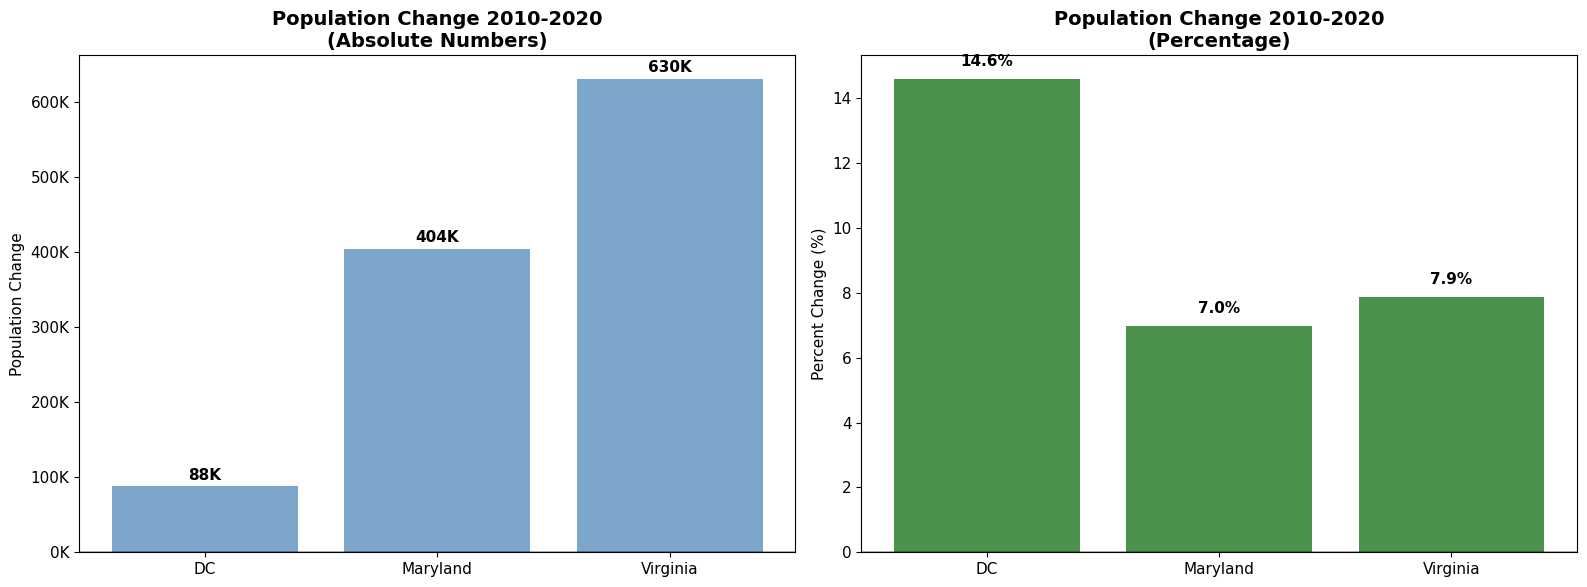

DC METRO AREA SUMMARY:
 Total 2010 Population: 14,376,299
 Total 2020 Population: 15,498,162
 Net Change: +1,121,863 (+7.8%)


In [7]:
# Step 4: Visualize the population changes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Chart 1: Absolute change
colors = ['red' if x < 0 else 'steelblue' for x in pop_change['change_absolute']]
bars1 = ax1.bar(pop_change['NAME'], pop_change['change_absolute'], color=colors, alpha=0.7)
ax1.set_title('Population Change 2010-2020\n(Absolute Numbers)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Population Change')
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))

# Add value labels on bars
for bar, value in zip(bars1, pop_change['change_absolute']):
 height = bar.get_height()
 ax1.text(bar.get_x() + bar.get_width()/2., height + (5000 if height >= 0 else -15000),
 f'{value/1000:.0f}K', ha='center', va='bottom' if height >= 0 else 'top', fontweight='bold')

# Chart 2: Percentage change
colors2 = ['red' if x < 0 else 'darkgreen' for x in pop_change['change_percent']]
bars2 = ax2.bar(pop_change['NAME'], pop_change['change_percent'], color=colors2, alpha=0.7)
ax2.set_title('Population Change 2010-2020\n(Percentage)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Percent Change (%)')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars2, pop_change['change_percent']):
 height = bar.get_height()
 ax2.text(bar.get_x() + bar.get_width()/2., height + (0.3 if height >= 0 else -0.8),
 f'{value:.1f}%', ha='center', va='bottom' if height >= 0 else 'top', fontweight='bold')

plt.tight_layout()
plt.show()

# Summary statistics
total_2010 = pop_change['pop_2010'].sum()
total_2020 = pop_change['pop_2020'].sum()
total_change = total_2020 - total_2010
total_pct = (total_change / total_2010) * 100

print(f"DC METRO AREA SUMMARY:")
print(f" Total 2010 Population: {total_2010:,}")
print(f" Total 2020 Population: {total_2020:,}")
print(f" Net Change: {total_change:+,} ({total_pct:+.1f}%)")

## Part 2: Income Change Analysis (ACS 5-Year Data)

Now let's analyze how median household income changed in the DC metro area using **ACS 5-year data**. We'll compare 2012 (2008-2012 ACS) with 2022 (2018-2022 ACS).

### Why These Years?
- **2012 ACS 5-year**: Represents 2008-2012 period (includes recession and early recovery)
- **2022 ACS 5-year**: Represents 2018-2022 period (includes pre-COVID and COVID era)
- **10-year gap**: Provides meaningful temporal separation and reduces overlap in survey periods

### Important Note: Inflation Adjustment
The dollar values in ACS data are **inflation-adjusted** to the last year of the survey period:
- 2012 ACS data is in 2012 dollars
- 2022 ACS data is in 2022 dollars

To compare "real" changes in purchasing power, you should adjust for inflation. For this tutorial, we'll show both nominal (unadjusted) and note where real (inflation-adjusted) comparisons would differ.

### County-Level Analysis
We'll look at specific counties in the DC metro area that are economically important.

In [8]:
# Define the counties we want to analyze
counties_to_analyze = [
 {"state": "DC", "county": None, "display_name": "Washington DC"},
 {"state": "MD", "county": "Montgomery County", "display_name": "Montgomery County, MD"},
 {"state": "VA", "county": "Arlington County", "display_name": "Arlington County, VA"},
 {"state": "VA", "county": "Fairfax County", "display_name": "Fairfax County, VA"}
]

print("Target Counties for Income Analysis:")
for county in counties_to_analyze:
 print(f" • {county['display_name']}")
print()
print("Variable: B19013_001E (Median Household Income in the Past 12 Months)")
print("Comparing: 2012 ACS 5-year vs 2022 ACS 5-year")
print()
print(" Remember: These are NOMINAL dollars (not inflation-adjusted)")

Target Counties for Income Analysis:
 • Washington DC
 • Montgomery County, MD
 • Arlington County, VA
 • Fairfax County, VA

Variable: B19013_001E (Median Household Income in the Past 12 Months)
Comparing: 2012 ACS 5-year vs 2022 ACS 5-year

 Remember: These are NOMINAL dollars (not inflation-adjusted)


In [9]:
# Step 1: Get 2012 ACS income data
print(" Fetching 2012 ACS 5-year data (2008-2012)...")

income_2012_data = []

for county_info in counties_to_analyze:
 try:
 income_data = tc.get_acs(
 geography="county",
 variables={"median_income": "B19013_001E"},
 state=county_info["state"],
 county=county_info["county"], # None for DC (state-equivalent)
 year=2012,
 survey="acs5",
 output="wide"
 )
 
 # Add display name for easier tracking
 income_data['display_name'] = county_info['display_name']
 income_2012_data.append(income_data)
 
 print(f" {county_info['display_name']}: ${income_data.iloc[0]['median_income']:,}")
 
 except Exception as e:
 print(f" {county_info['display_name']}: Error - {str(e)[:60]}...")

# Combine all 2012 data
if income_2012_data:
 income_2012_combined = pd.concat(income_2012_data, ignore_index=True)
 print(f"\n Successfully retrieved 2012 data for {len(income_2012_combined)} counties")
else:
 print("\n No 2012 data retrieved")

 Fetching 2012 ACS 5-year data (2008-2012)...
Getting data from the 2008-2012 5-year ACS
 Washington DC: $64,267
Getting data from the 2008-2012 5-year ACS
 Montgomery County, MD: $96,985
Getting data from the 2008-2012 5-year ACS
 Arlington County, VA: $102,459
Getting data from the 2008-2012 5-year ACS
 Fairfax County, VA: $109,383

 Successfully retrieved 2012 data for 4 counties


In [10]:
# Step 2: Get 2022 ACS income data
print(" Fetching 2022 ACS 5-year data (2018-2022)...")

income_2022_data = []

for county_info in counties_to_analyze:
 try:
 income_data = tc.get_acs(
 geography="county",
 variables={"median_income": "B19013_001E"},
 state=county_info["state"],
 county=county_info["county"],
 year=2022,
 survey="acs5",
 output="wide"
 )
 
 income_data['display_name'] = county_info['display_name']
 income_2022_data.append(income_data)
 
 print(f" {county_info['display_name']}: ${income_data.iloc[0]['median_income']:,}")
 
 except Exception as e:
 print(f" {county_info['display_name']}: Error - {str(e)[:60]}...")

# Combine all 2022 data
if income_2022_data:
 income_2022_combined = pd.concat(income_2022_data, ignore_index=True)
 print(f"\n Successfully retrieved 2022 data for {len(income_2022_combined)} counties")
else:
 print("\n No 2022 data retrieved")

 Fetching 2022 ACS 5-year data (2018-2022)...
Getting data from the 2018-2022 5-year ACS
 Washington DC: $101,722
Getting data from the 2018-2022 5-year ACS
 Montgomery County, MD: $125,583
Getting data from the 2018-2022 5-year ACS
 Arlington County, VA: $137,387
Getting data from the 2018-2022 5-year ACS
 Fairfax County, VA: $145,165

 Successfully retrieved 2022 data for 4 counties


In [11]:
# Step 3: Calculate income changes
if 'income_2012_combined' in locals() and 'income_2022_combined' in locals():
 print(" Calculating income changes...")
 
 # Merge data on display name
 income_change = pd.merge(
 income_2012_combined[['display_name', 'median_income']].rename(columns={'median_income': 'income_2012'}),
 income_2022_combined[['display_name', 'median_income']].rename(columns={'median_income': 'income_2022'}),
 on='display_name'
 )
 
 # Calculate changes
 income_change['change_absolute'] = income_change['income_2022'] - income_change['income_2012']
 income_change['change_percent'] = (income_change['change_absolute'] / income_change['income_2012']) * 100
 
 # Note: For "real" change adjusted for inflation, you'd need to apply CPI adjustment
 # Example: If CPI increased 25% from 2012-2022, real income change would be:
 # real_change_percent = ((income_2022 / 1.25) - income_2012) / income_2012 * 100
 
 print(" Income change analysis complete!")
 print("\nMedian Income Change Summary (2012-2022):")
 print("=" * 70)
 print(" Note: These are NOMINAL changes (not adjusted for inflation)")
 print()
 
 for _, row in income_change.iterrows():
 print(f" {row['display_name']}:")
 print(f" 2012: ${row['income_2012']:,} (in 2012 dollars)")
 print(f" 2022: ${row['income_2022']:,} (in 2022 dollars)")
 print(f" Nominal Change: ${row['change_absolute']:+,} ({row['change_percent']:+.1f}%)")
 print()
 
 print(" Interpretation Tip:")
 print(" To assess 'real' purchasing power changes, you'd need to adjust")
 print(" for inflation. If inflation was ~30% from 2012-2022, areas with")
 print(" <30% income growth actually lost purchasing power.")
 
else:
 print(" Cannot calculate changes - missing data")
 income_change = pd.DataFrame() # Empty dataframe for later checks

 Calculating income changes...
 Income change analysis complete!

Median Income Change Summary (2012-2022):
 Note: These are NOMINAL changes (not adjusted for inflation)

 Washington DC:
 2012: $64,267 (in 2012 dollars)
 2022: $101,722 (in 2022 dollars)
 Nominal Change: $+37,455 (+58.3%)

 Montgomery County, MD:
 2012: $96,985 (in 2012 dollars)
 2022: $125,583 (in 2022 dollars)
 Nominal Change: $+28,598 (+29.5%)

 Arlington County, VA:
 2012: $102,459 (in 2012 dollars)
 2022: $137,387 (in 2022 dollars)
 Nominal Change: $+34,928 (+34.1%)

 Fairfax County, VA:
 2012: $109,383 (in 2012 dollars)
 2022: $145,165 (in 2022 dollars)
 Nominal Change: $+35,782 (+32.7%)

 Interpretation Tip:
 To assess 'real' purchasing power changes, you'd need to adjust
 for inflation. If inflation was ~30% from 2012-2022, areas with
 <30% income growth actually lost purchasing power.


/tmp/ipykernel_2211468/266238594.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
 ax2.set_xticklabels(ax2.get_xticklabels(), ha='right')


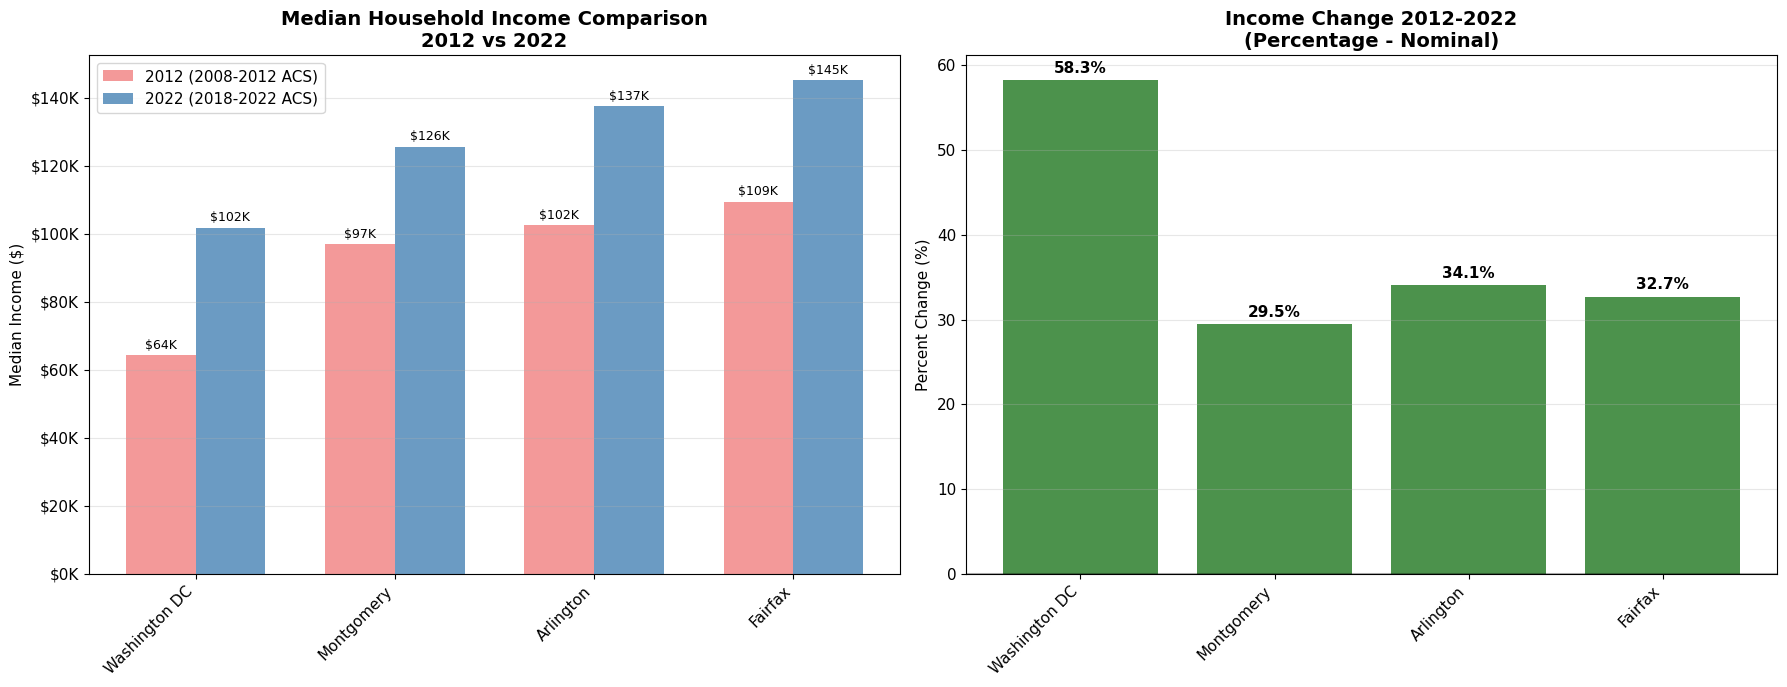


INCOME ANALYSIS SUMMARY:
 Average nominal income change: 38.6%
 Counties with income growth: 4
 Counties with income decline: 0

 Remember: These are nominal changes.
 Adjust for ~30% inflation (2012-2022) to assess real purchasing power.


In [12]:
# Step 4: Visualize income changes
if not income_change.empty:
 fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
 
 # Chart 1: Income levels comparison
 x = np.arange(len(income_change))
 width = 0.35
 
 bars1 = ax1.bar(x - width/2, income_change['income_2012'], width, 
 label='2012 (2008-2012 ACS)', color='lightcoral', alpha=0.8)
 bars2 = ax1.bar(x + width/2, income_change['income_2022'], width,
 label='2022 (2018-2022 ACS)', color='steelblue', alpha=0.8)
 
 ax1.set_title('Median Household Income Comparison\n2012 vs 2022', fontsize=14, fontweight='bold')
 ax1.set_ylabel('Median Income ($)')
 ax1.set_xticks(x)
 ax1.set_xticklabels([name.replace(' County', '').replace(', VA', '').replace(', MD', '') 
 for name in income_change['display_name']], rotation=45, ha='right')
 ax1.legend()
 ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
 ax1.grid(axis='y', alpha=0.3)
 
 # Add value labels
 for bar in bars1:
 height = bar.get_height()
 ax1.text(bar.get_x() + bar.get_width()/2., height + 1000,
 f'${height/1000:.0f}K', ha='center', va='bottom', fontsize=9)
 
 for bar in bars2:
 height = bar.get_height()
 ax1.text(bar.get_x() + bar.get_width()/2., height + 1000,
 f'${height/1000:.0f}K', ha='center', va='bottom', fontsize=9)
 
 # Chart 2: Percentage change
 colors = ['red' if x < 0 else 'darkgreen' for x in income_change['change_percent']]
 bars3 = ax2.bar(income_change['display_name'].str.replace(' County', '').str.replace(', VA', '').str.replace(', MD', ''),
 income_change['change_percent'], color=colors, alpha=0.7)
 
 ax2.set_title('Income Change 2012-2022\n(Percentage - Nominal)', fontsize=14, fontweight='bold')
 ax2.set_ylabel('Percent Change (%)')
 ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
 ax2.tick_params(axis='x', rotation=45)
 ax2.set_xticklabels(ax2.get_xticklabels(), ha='right')
 ax2.grid(axis='y', alpha=0.3)
 
 # Add value labels
 for bar, value in zip(bars3, income_change['change_percent']):
 height = bar.get_height()
 ax2.text(bar.get_x() + bar.get_width()/2., height + (0.5 if height >= 0 else -1.5),
 f'{value:.1f}%', ha='center', va='bottom' if height >= 0 else 'top', fontweight='bold')
 
 plt.tight_layout()
 plt.show()
 
 # Summary statistics
 avg_change = income_change['change_percent'].mean()
 print(f"\nINCOME ANALYSIS SUMMARY:")
 print(f" Average nominal income change: {avg_change:.1f}%")
 print(f" Counties with income growth: {(income_change['change_percent'] > 0).sum()}")
 print(f" Counties with income decline: {(income_change['change_percent'] < 0).sum()}")
 print(f"\n Remember: These are nominal changes.")
 print(f" Adjust for ~30% inflation (2012-2022) to assess real purchasing power.")
 
else:
 print(" Cannot create visualization - no income data available")
 print(" This might be due to API key issues or data availability")

## Part 3: Understanding Your Results

### What Do These Numbers Mean?

**Population Changes (Decennial Census)**
- Shows actual population growth or decline
- DC typically shows high growth due to urban revitalization
- Suburban areas may show different patterns

**Income Changes (ACS 5-Year)**
- Reflects economic conditions over time
- Adjusted for inflation, this shows real purchasing power changes
- High-income areas often show faster income growth

### Important Considerations

In [13]:
# Let's discuss data quality and limitations
print(" IMPORTANT DATA QUALITY CONSIDERATIONS:")
print("=" * 60)
print()
print(" DECENNIAL CENSUS:")
print(" Advantages:")
print(" Complete population count (not a sample)")
print(" Very accurate for population totals")
print(" Available for all geographic levels")
print(" Minimal margin of error")
print(" Limitations:")
print(" Only every 10 years")
print(" Limited variables (basic demographics only)")
print(" 2020 data uses differential privacy (slight noise added)")
print()
print(" ACS 5-YEAR:")
print(" Advantages:")
print(" Rich set of variables (income, education, housing, etc.)")
print(" Annual updates")
print(" Available for small geographies")
print(" Larger sample size than ACS 1-year")
print(" Limitations:")
print(" Sample-based (margins of error)")
print(" 5-year averages may mask recent changes")
print(" Smaller areas have larger margins of error")
print(" Inflation adjustment needed for dollar values")
print()
print(" BEST PRACTICES:")
print(" 1. Always check margins of error for ACS data")
print(" 2. Adjust for inflation when comparing dollar values")
print(" 3. Look for consistent patterns across multiple indicators")
print(" 4. Document your methodology and assumptions")
print(" 5. Use appropriate geographic levels for your questions")
print(" 6. Consider survey overlap when choosing years to compare")
print()
print(" MARGIN OF ERROR GUIDANCE:")
print(" • Small MOE/Estimate ratio (<10%): Reliable estimate")
print(" • Medium MOE/Estimate ratio (10-30%): Use with caution")
print(" • Large MOE/Estimate ratio (>30%): Unreliable estimate")

 IMPORTANT DATA QUALITY CONSIDERATIONS:

 DECENNIAL CENSUS:
 Advantages:
 Complete population count (not a sample)
 Very accurate for population totals
 Available for all geographic levels
 Minimal margin of error
 Limitations:
 Only every 10 years
 Limited variables (basic demographics only)
 2020 data uses differential privacy (slight noise added)

 ACS 5-YEAR:
 Advantages:
 Rich set of variables (income, education, housing, etc.)
 Annual updates
 Available for small geographies
 Larger sample size than ACS 1-year
 Limitations:
 Sample-based (margins of error)
 5-year averages may mask recent changes
 Smaller areas have larger margins of error
 Inflation adjustment needed for dollar values

 BEST PRACTICES:
 1. Always check margins of error for ACS data
 2. Adjust for inflation when comparing dollar values
 3. Look for consistent patterns across multiple indicators
 4. Document your methodology and assumptions
 5. Use appropriate geographic levels for your questions
 6. Consider surv

## CRITICAL: Avoiding Overlapping ACS Periods

### Understanding ACS Multi-Year Estimates

When working with ACS 5-year or 3-year estimates, it's essential to understand what each "year" represents:

**ACS 5-Year Example:**
- **2012 ACS5** = Data from 2008, 2009, 2010, 2011, 2012
- **2013 ACS5** = Data from 2009, 2010, 2011, 2012, 2013
- **2017 ACS5** = Data from 2013, 2014, 2015, 2016, 2017
- **2022 ACS5** = Data from 2018, 2019, 2020, 2021, 2022

### The Overlap Problem

**BAD: Years 2012 and 2013**
- 2012 ACS5 (2008-2012) and 2013 ACS5 (2009-2013) share **4 years** of data!
- Creates statistical dependence
- Violates assumptions for valid comparisons

**GOOD: Years 2012 and 2017**
- 2012 ACS5 (2008-2012) and 2017 ACS5 (2013-2017) share **0 years** of data
- Statistically independent
- Valid for formal comparisons

**GOOD: Years 2012 and 2022** 
- 2012 ACS5 (2008-2012) and 2022 ACS5 (2018-2022) share **0 years** of data
- 10-year gap provides strong temporal separation
- Ideal for trend analysis

### What You CANNOT Do With Overlapping Periods

When periods overlap, you CANNOT:
- Perform statistical hypothesis tests (t-tests, chi-square, etc.)
- Calculate valid confidence intervals for change
- Claim "statistically significant" differences
- Do regression analysis treating years as independent
- Make formal statistical inferences about trends

### What You CAN Do

**For Non-Overlapping Periods (Recommended):**
- All statistical tests and inference
- Formal trend analysis
- Publication-quality research
- Policy analysis with statistical backing

**For Overlapping Periods (Descriptive Only):**
- Describe general patterns
- Visualize trends (label as "descriptive only")
- Explore data for hypothesis generation
- Show context in reports (with appropriate caveats)

### Recommended Time Gaps

**For ACS 5-Year Estimates:**
- **Minimum gap:** 5 years (e.g., 2012, 2017, 2022)
- **Better gap:** 10 years (e.g., 2012, 2022)
- **Why:** Each period represents 5 years, so 5-year gaps ensure no overlap

**For ACS 3-Year Estimates (discontinued after 2013):**
- **Minimum gap:** 3 years
- **Each year represents:** 3 years of data

**For ACS 1-Year Estimates:**
- **No overlap concerns!** Each year is independent
- Available only for geographies with 65,000+ population
- Best for annual trend analysis of large areas

### pytidycensus Helps You

Starting with version 0.2.0, pytidycensus automatically warns you when you request overlapping ACS periods:

```python
# This will trigger a warning:
data = tc.get_time_series(
    geography="county",
    variables={"total_pop": "B01003_001E"},
    years=[2019, 2020, 2021],  # All overlapping!
    dataset="acs5",
    state="CA"
)
```

The warning explains exactly why this is problematic and what you should do instead.

### This Tutorial's Approach

In this tutorial, we use **10-year gaps** (2012 vs 2022) which ensures:
- Complete independence between periods
- Valid statistical comparisons
- Meaningful temporal change
- Best practice for research

### Learn More

- [Census Bureau: Comparing ACS Data](https://www.census.gov/programs-surveys/acs/guidance/comparing-acs-data.html)
- [When to Use 1-year, 3-year, or 5-year Estimates](https://www.census.gov/programs-surveys/acs/guidance/estimates.html)